In [1]:
%matplotlib inline
import plot
import market
import metrics
from decimal import Decimal
import withdrawal
import harvesting
import simulate
import lens
import pandas
import seaborn
from matplotlib import pyplot as plt
import matplotlib

In [2]:
seaborn.set(style='whitegrid')
seaborn.set_context('poster')

In [3]:
m = market.Returns_US_1871()

s = simulate.calc_lens(harvesting.N_60_RebalanceHarvesting,
          lambda p, h: withdrawal.ConstantDollar(p, h, rate=Decimal('.043')),
          30,
          lens.calc_success
         )
len(s[s == False])

5

In [4]:
class ReRetiring(withdrawal.WithdrawalStrategy):
    def __init__(self, portfolio, harvest, rate=Decimal('.04'), ratchet=Decimal('1.05')):
        super().__init__(portfolio, harvest)
        self.rate = rate
        self.previous_withdrawal = portfolio.value * rate
        self.previous_portfolio = portfolio.value
        self.ratchet = ratchet
        
    def start(self):
        return self.previous_withdrawal
    
    def next(self):
        # adjust for inflation
        current_wd = self.previous_withdrawal * (1 + self.current_inflation)
        
        # was this a "good" year? If so, reset
        if self.portfolio.value > (self.previous_portfolio * self.ratchet):
            new_wd = self.portfolio.value * self.rate
            current_wd = max(new_wd, current_wd)
            self.previous_portfolio = self.portfolio.value
        
        self.previous_withdrawal = current_wd
        return current_wd

In [5]:
s = simulate.calc_lens(harvesting.N_60_RebalanceHarvesting,
          lambda p, h: ReRetiring(p, h, rate=Decimal('.043'), ratchet=Decimal('1.05')),
          30,
          lens.calc_success
         )
len(s[s == False])

10

In [6]:
YEAR = 1965

sim_rere = simulate.withdrawals(m.iter_from(YEAR),
                    years=30,
                    harvesting=harvesting.N_60_RebalanceHarvesting,
                    withdraw=ReRetiring)
#pandas.DataFrame(data=[s.portfolio_post.value_r for s in sim])
#pandas.DataFrame(data=[s.withdraw_r for s in sim])

In [7]:
sim_normal = simulate.withdrawals(m.iter_from(YEAR),
                    years=30,
                    harvesting=harvesting.N_60_RebalanceHarvesting,
                    withdraw=withdrawal.ConstantDollar)
#pandas.DataFrame(data=[s.portfolio_post.value_r for s in sim])
#pandas.DataFrame(data=[s.withdraw_r for s in sim])

<AxesSubplot:>

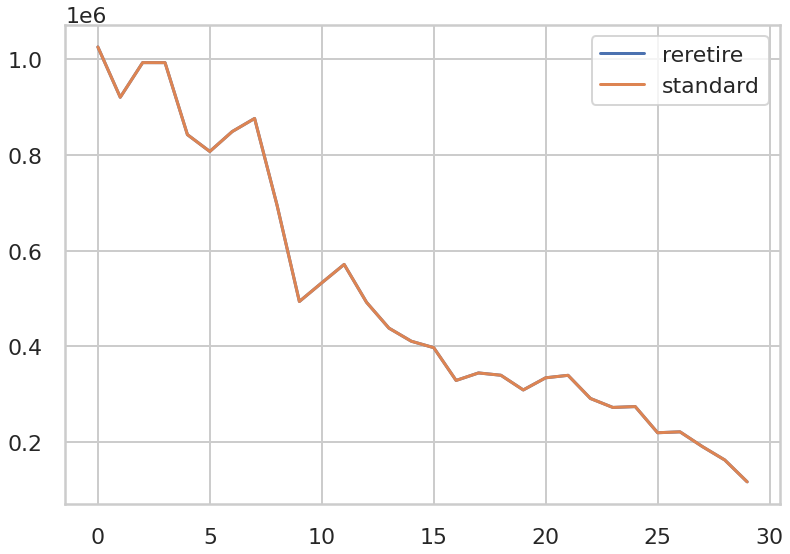

In [8]:
pandas.DataFrame(data={
    'reretire': [float(s.portfolio_post.value_r) for s in sim_rere],
    'standard': [float(s.portfolio_post.value_r) for s in sim_normal],
}).plot()

In [9]:
def final_portfolio_value(annual):
    df = pandas.DataFrame(annual)
    fv = df.tail(1)['portfolio_post'].item().value_r
    return float(fv)

s_rere = simulate.calc_lens(harvesting.N_60_RebalanceHarvesting,
          ReRetiring,
          30,
          final_portfolio_value
         )
s_normal = simulate.calc_lens(harvesting.N_60_RebalanceHarvesting,
          withdrawal.ConstantDollar,
          30,
          final_portfolio_value
         )

<AxesSubplot:title={'center':'Final Portfolio Values'}>

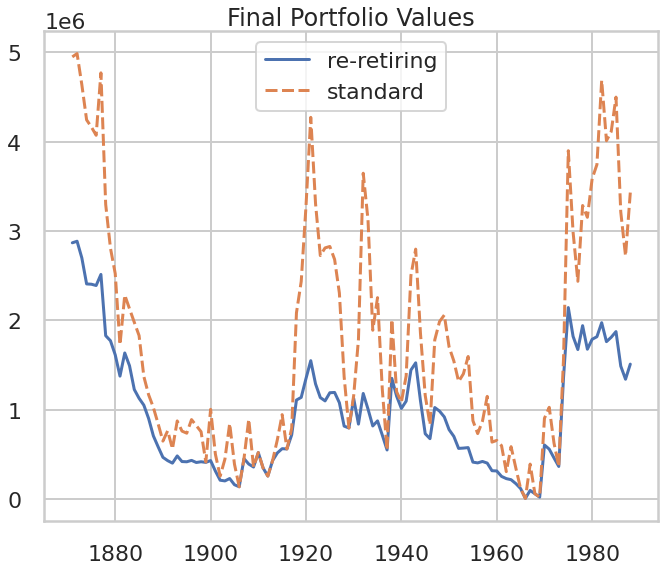

In [10]:
df = pandas.DataFrame(data={
    're-retiring': s_rere,
    'standard': s_normal
})
plt.figure(figsize=(11,9))
plt.title(f'Final Portfolio Values')
seaborn.lineplot(data=df)

In [11]:
class Increase(withdrawal.WithdrawalStrategy):
    def __init__(self, portfolio, harvest, rate=Decimal('.04'), ratchet=Decimal('1.03')):
        super().__init__(portfolio, harvest)
        self.rate = rate
        self.previous_withdrawal = portfolio.value * rate
        self.ratchet = ratchet
        
    def start(self):
        return self.previous_withdrawal
    
    def next(self):
        self.previous_withdrawal = self.previous_withdrawal * self.ratchet
        return self.previous_withdrawal

In [12]:
s_three = simulate.calc_lens(harvesting.N_60_RebalanceHarvesting,
          Increase,
          30,
          final_portfolio_value
         )

<AxesSubplot:title={'center':'Final Portfolio Values'}>

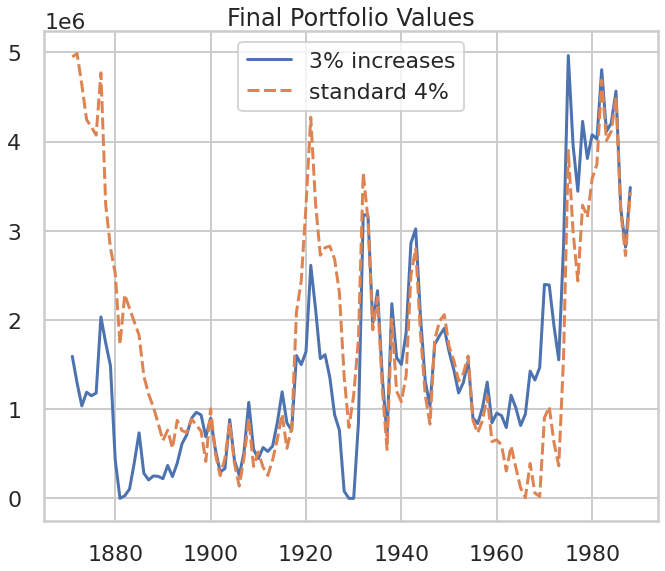

In [13]:
df = pandas.DataFrame(data={
    '3% increases': s_three,
    'standard 4%': s_normal
})
plt.figure(figsize=(11,9))
plt.title(f'Final Portfolio Values')
seaborn.lineplot(data=df)

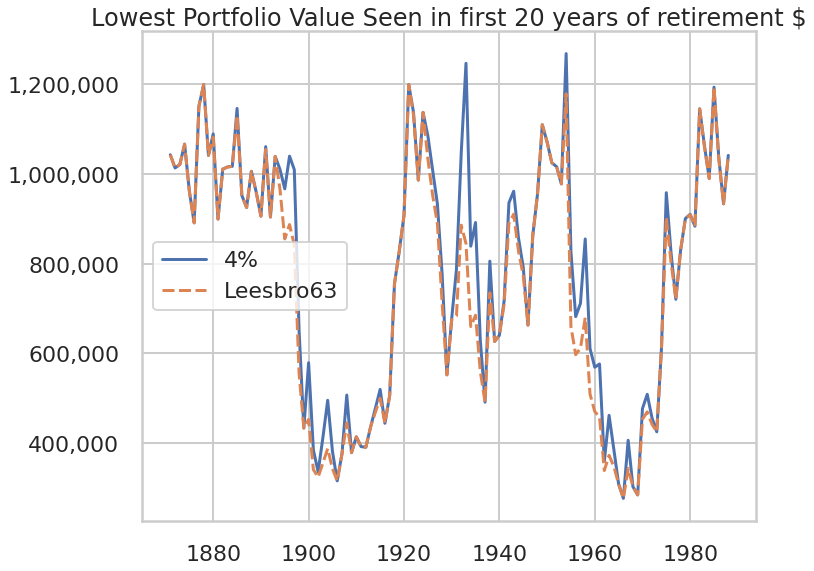

In [14]:
def min_portfolio_value(annual):    
    df = pandas.DataFrame([n.portfolio_post.value_r for n in annual])
    return float(df[:20].min())

s_normal = simulate.calc_lens(harvesting.N_60_RebalanceHarvesting,
          withdrawal.ConstantDollar,
          30,
          min_portfolio_value
         )
s_three = simulate.calc_lens(harvesting.N_60_RebalanceHarvesting,
          ReRetiring,
          30,
          min_portfolio_value
         )
df = pandas.DataFrame(data={
    '4%': s_normal,
    'Leesbro63': s_three
})
plt.figure(figsize=(11,9))
plt.title(f'Lowest Portfolio Value Seen in first 20 years of retirement $')
g = seaborn.lineplot(data=df)
g.axes.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

In [15]:
diff = s_normal[s_normal < 600_000] - s_three
diff[diff > 0]

1899       662.602646
1900    126260.016801
1901     43873.794917
1902     11781.532676
1903     57014.935413
1904    107533.246875
1905     38830.415754
1908     61994.720986
1914      8756.608678
1915     19799.806159
1960     98785.212533
1961    118317.412200
1962     19943.583526
1963     89152.245889
1964     37918.680840
1967     62782.205078
1970     23873.741864
1971     39050.965539
1972     14140.207489
dtype: float64

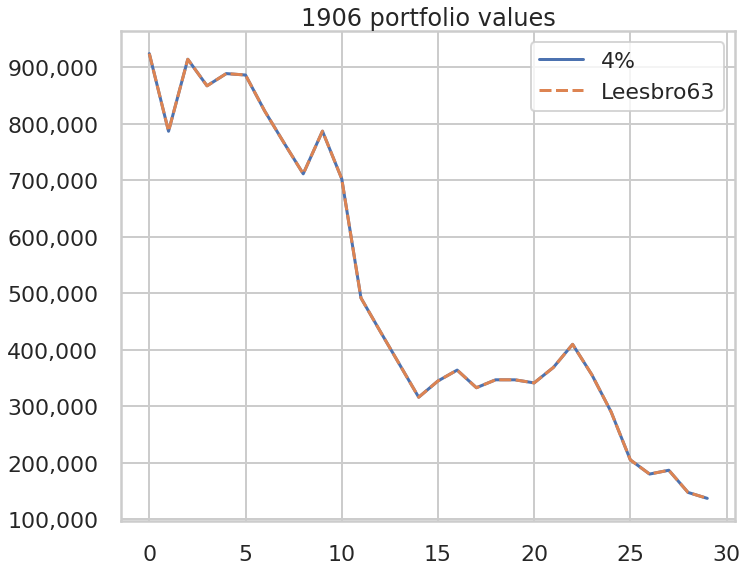

In [16]:
YEAR = 1906
sim_normal = simulate.withdrawals(m.iter_from(YEAR),
                    years=30,
                    harvesting=harvesting.N_60_RebalanceHarvesting,
                    withdraw=withdrawal.ConstantDollar)
sim_rere = simulate.withdrawals(m.iter_from(YEAR),
                    years=30,
                    harvesting=harvesting.N_60_RebalanceHarvesting,
                    withdraw=ReRetiring)
plt.figure(figsize=(11,9))
plt.title(f'{YEAR} portfolio values')
df = pandas.DataFrame(data={'4%': [int(s.portfolio_post.value_r) for s in sim_normal],
                            'Leesbro63': [int(s.portfolio_post.value_r) for s in sim_rere]
                           })
g = seaborn.lineplot(data=df)
g.axes.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
#pandas.DataFrame(data=[s.withdraw_r for s in sim])

In [17]:
s_normal[s_normal < 300_000]

1966    277223.471400
1969    285006.020558
dtype: float64

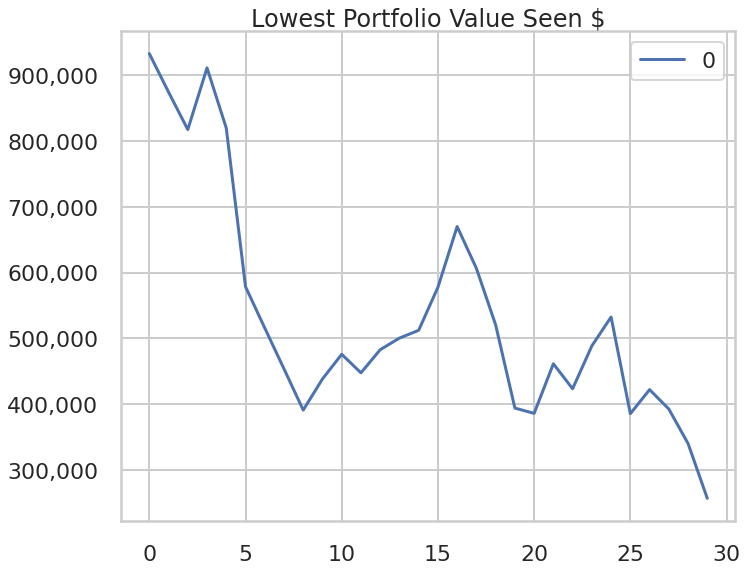

In [18]:
sim = simulate.withdrawals(m.iter_from(1912),
                    years=30,
                    harvesting=harvesting.N_60_RebalanceHarvesting,
                    withdraw=withdrawal.ConstantDollar)
plt.figure(figsize=(11,9))
plt.title(f'Lowest Portfolio Value Seen $')
g = seaborn.lineplot(data=pandas.DataFrame(data=[int(s.portfolio_post.value_r) for s in sim]))
g.axes.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
#pandas.DataFrame(data=[s.withdraw_r for s in sim])

1.371879133010032


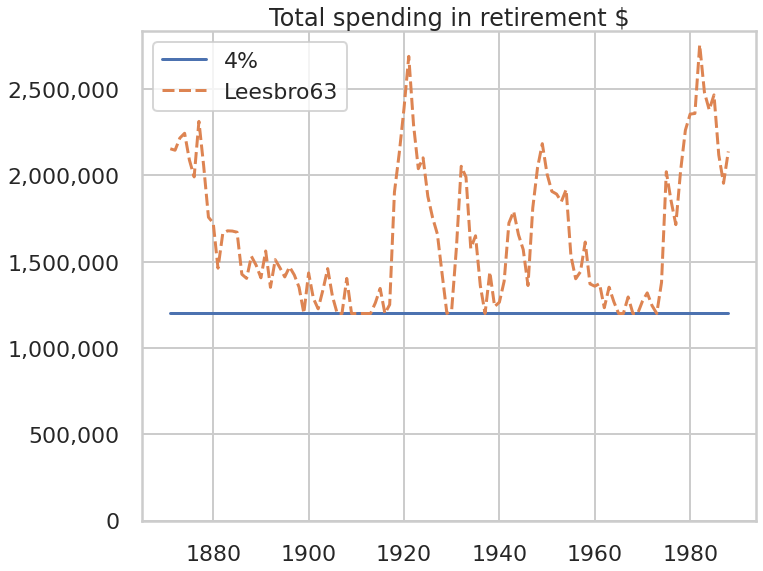

In [19]:
def sum_spending(annual):    
    df = pandas.DataFrame([n.withdraw_r for n in annual])
    return float(df.sum())

s_normal = simulate.calc_lens(harvesting.N_60_RebalanceHarvesting,
          withdrawal.ConstantDollar,
          30,
          sum_spending
         )
s_three = simulate.calc_lens(harvesting.N_60_RebalanceHarvesting,
          ReRetiring,
          30,
          sum_spending
         )
df = pandas.DataFrame(data={
    '4%': s_normal,
    'Leesbro63': s_three
})
plt.figure(figsize=(11,9))
plt.title(f'Total spending in retirement $')
g = seaborn.lineplot(data=df)
g.axes.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.ylim(bottom=0)
print(s_three.sum() / s_normal.sum())